In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


def prepare_data(filepath):
    """Load and prepare data with required __id__ column"""
    df = pd.read_csv(filepath, parse_dates=['date'])
    df['__id__'] = "main_series"  # Single time series ID
    
    # Add temporal features
    for col in ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']:
        df[f'{col}_3mo_ma'] = df[col].rolling(3, min_periods=1).mean()
        df[f'{col}_12mo_ma'] = df[col].rolling(12, min_periods=6).mean()
    
    return df.set_index('date').sort_index()


def prepare_covariates(test_df:pd.DataFrame, target_col:str):
    """Prepare known covariates from test data for evaluation"""
    # Extract all columns except the target we're predicting
    covariate_cols = [col for col in test_df.columns if col not in [target_col, '__id__', 'Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']]
    
    # Create TimeSeriesDataFrame with the test period covariates
    test_covs = test_df[[target_col]+covariate_cols].copy()
    test_covs['__id__'] = "main_series"  # Add ID column
    
    return TimeSeriesDataFrame.from_data_frame(
        test_covs.reset_index(),
        id_column="__id__",
        timestamp_column="date"
    )


def create_ts_dataframe(df:pd.DataFrame, target_col:str):
    """Create properly formatted TimeSeriesDataFrame"""
    # Keep only relevant columns
    keep_cols = ['__id__', target_col] + [col for col in df.columns if col not in ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price', '__id__']]

    # Prepare known covariates (all features except other commodities)
    # covariates = [f for f in keep_cols if f not in ['__id__'] and f != target]
    # covariates = [f for f in keep_cols if f != target]
    # covariates = [f for f in keep_cols if f not in ['__id__', target_col]]

    return TimeSeriesDataFrame.from_data_frame(
        df[keep_cols].reset_index(),
        id_column="__id__",
        timestamp_column="date"
    )


def run_automl_forecasting(ts_data:TimeSeriesDataFrame, target_col:str, prediction_length=12):
    """Run AutoML forecasting for a single target"""

    # Identify covariates - all columns except target and __id__
    # known_covariates = [col for col in ts_data.columns if col not in [target_col, '__id__']]
    # known_covariates_data = ts_data[known_covariates]  # Extract as TimeSeriesDataFrame

    predictor = TimeSeriesPredictor(
        target=target_col,
        prediction_length=prediction_length,
        eval_metric="RMSE",
        path=f"autogluon_models/{target_col.replace(' ', '_')}",
    )
    
    predictor.fit(
        train_data=ts_data,
        time_limit=None,  # 1hour (3600) | None
        presets="medium_quality",
        hyperparameters={
            "DeepARModel": {"num_layers": 4},
            "SimpleFeedForwardModel": {"hidden_dimensions":[256,128]},
            "TemporalFusionTransformerModel": {},
            "PatchTSTModel": {},
            "DLinearModel": {},
            "TiDEModel": {},
            "WaveNetModel": {}
        },
        enable_ensemble=True,
        num_val_windows=3,  # 3-fold time-based validation
        verbosity=2,
    )
    
    return predictor


def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics for time series forecasts"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,  # as percentage
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }


def plot_actual_vs_predicted(train_df:pd.DataFrame, test_df:pd.DataFrame, forecast_df:pd.DataFrame, target_col:str):
    """Interactive plot of actual vs predicted values"""
    fig = go.Figure()
    
    # Convert indices to datetime
    train_df.index = pd.to_datetime(train_df.index)
    test_df.index = pd.to_datetime(test_df.index)
    forecast_df.index = pd.to_datetime(forecast_df.index)
    
    # Training data
    fig.add_trace(go.Scatter(
        x=train_df.index,
        y=train_df[target_col],
        name='Training Data',
        line=dict(color='blue')
    ))
    
    # Test actuals
    fig.add_trace(go.Scatter(
        x=test_df.index,
        y=test_df[target_col],
        name='Actual Test Values',
        line=dict(color='green')
    ))
    
    # Forecasts (ensure proper alignment)
    forecast_start = test_df.index[0]
    forecast_dates = pd.date_range(
        start=forecast_start,
        periods=len(forecast_df),
        freq='ME'
    )
    
    fig.add_trace(go.Scatter(
        x=forecast_dates,
        y=forecast_df['mean'],
        name='Forecast',
        line=dict(color='red')
    ))
    
    # Confidence interval
    fig.add_trace(go.Scatter(
        x=forecast_dates.tolist() + forecast_dates[::-1].tolist(),
        y=forecast_df['0.9'].tolist() + forecast_df['0.1'][::-1].tolist(),
        fill='toself',
        fillcolor='rgba(255,0,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        name='80% Confidence'
    ))
    
    fig.update_layout(
        title=f'{target_col} Forecast vs Actual',
        xaxis_title='Date',
        yaxis_title='Price',
        hovermode='x unified',
        template='plotly_white'
    )
    fig.show()

def plot_metrics(metrics_dict):
    """Bar plot comparing metrics across commodities"""
    metrics_df = pd.DataFrame(metrics_dict).T
    fig = px.bar(metrics_df, 
                 barmode='group',
                 title='Model Performance Across Commodities',
                 labels={'value': 'Metric Value', 'variable': 'Metric'})
    fig.update_layout(template='plotly_white')
    fig.show()


if __name__ == "__main__":
    # Configuration
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_PATH = "merged_macro_commodity.csv"
    COMMODITIES = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']
    PREDICTION_LENGTH = 12  # 12-month forecast
    
    # Prepare data
    full_df = prepare_data(DATA_PATH)
    train_df = full_df.iloc[:-PREDICTION_LENGTH]
    test_df = full_df.iloc[-PREDICTION_LENGTH:]
    
    results = {}
    for target in COMMODITIES:
        print(f"\n=== Processing {target} ===")
        
        # Prepare data
        train_ts = create_ts_dataframe(train_df, target)
        
        # Train model
        predictor = run_automl_forecasting(train_ts, target)

        # Prepare future covariates
        # test_covariates = prepare_covariates(test_df, target)
        # train_covariates = prepare_covariates(train_df, target)
        
        # Generate forecast
        forecast = predictor.predict(train_ts)

        # Generate forecast with error handling
        # try:
        #     print(f"Attempting to predict with covariates...")
        #     print(f"  - Train data shape: {train_ts.shape}")
        #     print(f"  - Test covariates shape: {test_covariates.shape}")
        #     print(f"  - Test covariates columns: {test_covariates.columns.tolist()}")
        #     print(f"  - Train_ts columns: {train_ts.columns.tolist()}")
            
        #     forecast = predictor.predict(train_ts, known_covariates=train_covariates_ts) # test_cov
        #     print("Successfully predicted with covariates!")
        # except ValueError as e:
        #     print(f"Error using covariates: {str(e)}")
        #     print("Falling back to prediction without covariates...")
        #     forecast = predictor.predict(train_ts)
        
        forecast_df = forecast.reset_index().set_index('timestamp')
        
        # Evaluate on test period
        y_true = test_df[target]
        y_pred = forecast_df['mean']
        metrics = calculate_metrics(y_true, y_pred)
        
        # Store results
        results[target] = {
            'metrics': metrics,
            'forecast': forecast_df,
            'predictor': predictor,
            'best_model': predictor.model_best
        }
        
        # Show interactive plot
        plot_actual_vs_predicted(train_df, test_df, forecast_df, target)
        
        print(f"\n{target} Evaluation:")
        print(f"best_model: {results[target]["best_model"]}")
        print(f"- MAE: {metrics['MAE']:.2f}")
        print(f"- MAPE: {metrics['MAPE']:.2f}%")
        print(f"- RMSE: {metrics['RMSE']:.2f}")
    
    # Compare metrics across commodities
    metrics_dict = {k: v['metrics'] for k, v in results.items()}
    plot_metrics(metrics_dict)

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Beginning AutoGluon training...
AutoGluon will save models to '/Users/purplegeminii/Desktop/Undergraduate Thesis/commodity_price_prediction/autogluon_models/Crude_Oil_Brent_Price'



=== Processing Crude Oil Brent Price ===


=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:          14
GPU Count:          0
Memory Avail:       6.34 GB / 24.00 GB (26.4%)
Disk Space Avail:   222.51 GB / 460.43 GB (48.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DLinearModel': {},
                     'DeepARModel': {'num_layers': 4},
                     'PatchTSTModel': {},
                     'SimpleFeedForwardModel': {'hidden_dimensions': [256,
                                                                      128]},
                     'TemporalFusionTransformerModel': {},
                     'TiDEModel': {},
                     'WaveNetModel': {}},
 'known_covariates_names': [],
 'num_val_wi

Beginning AutoGluon training...
AutoGluon will save models to '/Users/purplegeminii/Desktop/Undergraduate Thesis/commodity_price_prediction/autogluon_models/Cocoa_Price'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:          14
GPU Count:          0
Memory Avail:       6.33 GB / 24.00 GB (26.4%)
Disk Space Avail:   222.52 GB / 460.43 GB (48.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DLinearModel': {},
                     'DeepARModel': {'num_layers': 4},
                     'PatchTSTModel': {},
                     'SimpleFeedForwardModel': {'hidden_dimensions': [256,
                                                                      128]},
            


Crude Oil Brent Price Evaluation:
best_model: WeightedEnsemble
- MAE: 6.94
- MAPE: 9.00%
- RMSE: 8.97

=== Processing Cocoa Price ===


	-0.4218       = Validation score (-RMSE)
	143.23  s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model DeepAR. 
	-0.3452       = Validation score (-RMSE)
	117.92  s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model PatchTST. 
	-0.3948       = Validation score (-RMSE)
	40.20   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model TiDE. 
	-0.3544       = Validation score (-RMSE)
	54.39   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model WaveNet. 
	-0.3813       = Validation score (-RMSE)
	243.35  s     = Training runtime
	0.35    s     = Validation (prediction) runtime
Training timeseries model SimpleFeedForward. 
	-0.3317       = Validation score (-RMSE)
	12.78   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model DLinear. 
	-0.4536       = Validation

Beginning AutoGluon training...
AutoGluon will save models to '/Users/purplegeminii/Desktop/Undergraduate Thesis/commodity_price_prediction/autogluon_models/Gold_Price'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:          14
GPU Count:          0
Memory Avail:       6.43 GB / 24.00 GB (26.8%)
Disk Space Avail:   222.51 GB / 460.43 GB (48.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DLinearModel': {},
                     'DeepARModel': {'num_layers': 4},
                     'PatchTSTModel': {},
                     'SimpleFeedForwardModel': {'hidden_dimensions': [256,
                                                                      128]},
             


Cocoa Price Evaluation:
best_model: WeightedEnsemble
- MAE: 3.21
- MAPE: 40.95%
- RMSE: 3.57

=== Processing Gold Price ===


	-126.9953     = Validation score (-RMSE)
	148.08  s     = Training runtime
	0.01    s     = Validation (prediction) runtime
Training timeseries model DeepAR. 
	-137.2641     = Validation score (-RMSE)
	172.17  s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model PatchTST. 
	-85.6616      = Validation score (-RMSE)
	64.44   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model TiDE. 
	-153.1093     = Validation score (-RMSE)
	41.59   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model WaveNet. 
	-106.3638     = Validation score (-RMSE)
	232.14  s     = Training runtime
	0.36    s     = Validation (prediction) runtime
Training timeseries model SimpleFeedForward. 
	-128.8077     = Validation score (-RMSE)
	18.17   s     = Training runtime
	0.00    s     = Validation (prediction) runtime
Training timeseries model DLinear. 
	-168.6514     = Validation


Gold Price Evaluation:
best_model: WeightedEnsemble
- MAE: 309.02
- MAPE: 12.30%
- RMSE: 363.01


In [2]:
import torch, autogluon
print(f"Available GPUs: {torch.cuda.device_count()}")
print(f"PyTorch: {torch.__version__}")
print(f"AutoGluon-TimeSeries: {autogluon.timeseries.__version__}")
print(f"GPU Available?: {torch.cuda.is_available()}")

Available GPUs: 0
PyTorch: 2.5.1
AutoGluon-TimeSeries: 1.2
GPU Available?: False


In [3]:
print(f'crudeoil: {results["Crude Oil Brent Price"]["predictor"]}')
print(f'cocoa: {results["Cocoa Price"]["predictor"]}')
print(f'gold: {results["Gold Price"]["predictor"]}')

crudeoil: <autogluon.timeseries.predictor.TimeSeriesPredictor object at 0x17acc57f0>
cocoa: <autogluon.timeseries.predictor.TimeSeriesPredictor object at 0x17ac71c40>
gold: <autogluon.timeseries.predictor.TimeSeriesPredictor object at 0x3321b7c50>


In [4]:
crudeoil_results = results["Crude Oil Brent Price"]["predictor"].leaderboard().iloc[:,:2].rename(columns={'score_val':'crudeoil_score_val'})
crudeoil_results

,model,crudeoil_score_val
0,WeightedEnsemble,-8.976845
1,DLinear,-9.753381
2,TiDE,-10.579251
3,DeepAR,-10.924309
4,SimpleFeedForward,-14.126011
5,PatchTST,-14.211325
6,WaveNet,-16.312070
7,TemporalFusionTransformer,-28.168570


In [5]:
cocoa_results = results["Cocoa Price"]["predictor"].leaderboard().iloc[:,:2].rename(columns={'score_val':'cocoa_score_val'})
cocoa_results

,model,cocoa_score_val
0,WeightedEnsemble,-0.326548
1,SimpleFeedForward,-0.331668
2,DeepAR,-0.345152
3,TiDE,-0.354351
4,WaveNet,-0.381314
5,PatchTST,-0.394774
6,TemporalFusionTransformer,-0.421827
7,DLinear,-0.453622


In [6]:
gold_results = results["Gold Price"]["predictor"].leaderboard().iloc[:,:2].rename(columns={'score_val':'gold_score_val'})
gold_results

,model,gold_score_val
0,WeightedEnsemble,-79.942443
1,PatchTST,-85.661554
2,WaveNet,-106.363797
3,TemporalFusionTransformer,-126.995260
4,SimpleFeedForward,-128.807712
5,DeepAR,-137.264133
6,TiDE,-153.109312
7,DLinear,-168.651384


In [7]:
merged_results = pd.merge(crudeoil_results, cocoa_results, on="model")
merged_results = pd.merge(merged_results, gold_results, on="model")
merged_results.sort_values(by=['crudeoil_score_val', 'cocoa_score_val', 'gold_score_val'], ascending=False)

,model,crudeoil_score_val,cocoa_score_val,gold_score_val
0,WeightedEnsemble,-8.976845,-0.326548,-79.942443
1,DLinear,-9.753381,-0.453622,-168.651384
2,TiDE,-10.579251,-0.354351,-153.109312
3,DeepAR,-10.924309,-0.345152,-137.264133
4,SimpleFeedForward,-14.126011,-0.331668,-128.807712
5,PatchTST,-14.211325,-0.394774,-85.661554
6,WaveNet,-16.312070,-0.381314,-106.363797
7,TemporalFusionTransformer,-28.168570,-0.421827,-126.995260


In [8]:
# f"crudeoil mape: {results["Crude Oil Brent Price"]["metrics"]["MAPE"]:.2f}%"

In [9]:
full_df.describe()

,"Revenue, excluding grants (% of GDP)",GDP (constant 2015 US$),"Employment to population ratio (15+, total %)",Crude Oil Brent Price,Cocoa Price,Gold Price,Crude Oil Brent Price_3mo_ma,Crude Oil Brent Price_12mo_ma,Cocoa Price_3mo_ma,Cocoa Price_12mo_ma,Gold Price_3mo_ma,Gold Price_12mo_ma
count,408.000000,4.080000e+02,408.000000,408.000000,408.000000,408.000000,408.000000,403.000000,408.000000,403.000000,408.000000,403.000000
mean,16.616929,3.724039e+10,67.172923,53.780237,2.183022,927.032063,53.655044,53.399272,2.162741,2.104714,921.471495,904.549729
std,2.341241,1.957863e+10,3.399120,32.828573,1.178294,614.889160,32.645234,31.750334,1.106218,0.910264,608.905930,585.911597
min,11.900566,1.386282e+10,59.489757,9.800000,0.856900,256.080000,10.353333,12.008208,0.880000,0.905792,258.026667,267.876667
25%,14.691761,1.969137e+10,64.851770,21.775000,1.466000,360.069500,21.471667,20.990104,1.463792,1.456500,360.614167,360.976250
50%,16.483090,3.098749e+10,67.683811,50.357619,2.010423,804.725500,50.206372,51.243431,2.017340,2.016616,791.271667,765.847000
75%,17.809587,5.277785e+10,68.786394,76.779053,2.617109,1340.633500,76.904279,79.277610,2.566580,2.545956,1328.688534,1307.294430
max,23.712146,8.063873e+10,74.834000,133.873043,10.320510,2690.080000,130.285935,114.364602,8.516583,7.329646,2663.073333,2387.702500


In [10]:
results["Crude Oil Brent Price"]["predictor"].info()

{'path': '/Users/purplegeminii/Desktop/Undergraduate Thesis/commodity_price_prediction/autogluon_models/Crude_Oil_Brent_Price',
 'version': '1.2',
 'time_fit_training': 536.9436190128326,
 'time_limit': None,
 'best_model': 'WeightedEnsemble',
 'best_model_score_val': -8.976844989779183,
 'num_models_trained': 8,
 'model_info': {'TemporalFusionTransformer': {'name': 'TemporalFusionTransformer',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': RMSE,
   'fit_time': 86.45067572593689,
   'predict_time': 0.006362199783325195,
   'freq': 'MS',
   'prediction_length': 12,
   'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
   'val_score': -28.16856998162397,
   'hyperparameters': {},
   'info_per_val_window': [{'window_index': 0,
     'refit_this_window': True,
     'fit_time': 30.998071670532227,
     'val_score': -19.58589043162157,
     'predict_time': 0.006792783737182617},
    {'window_index': 1,
     'refit_this_window': True,
     'fit_time': 27.08922

GRANGER TEST

In [11]:
# Granger causality tests will be incorporated to establish directional relationships among the forecasted prices of cocoa, gold, and crude oil.

In [12]:
from statsmodels.tsa.stattools import grangercausalitytests

In [13]:
from itertools import combinations

max_lag=12
commodities = ['Cocoa Price', 'Gold Price', 'Crude Oil Brent Price']
results2 = {}

for x, y in combinations(commodities, 2):
    print(f"Testing if {x} Granger-causes {y}")
    result_xy = grangercausalitytests(full_df[[y, x]], maxlag=max_lag, verbose=False)
    results2[f'{x} → {y}'] = result_xy
    
    print(f"Testing if {y} Granger-causes {x}")
    result_yx = grangercausalitytests(full_df[[x, y]], maxlag=max_lag, verbose=False)
    results2[f'{y} → {x}'] = result_yx


Testing if Cocoa Price Granger-causes Gold Price
Testing if Gold Price Granger-causes Cocoa Price
Testing if Cocoa Price Granger-causes Crude Oil Brent Price
Testing if Crude Oil Brent Price Granger-causes Cocoa Price
Testing if Gold Price Granger-causes Crude Oil Brent Price
Testing if Crude Oil Brent Price Granger-causes Gold Price


/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions should not print results

/opt/anaconda3/envs/automl/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning:

verbose is deprecated since functions 

In [14]:
results2 = pd.DataFrame(results2)
pd.DataFrame(results).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, metrics to best_model
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Crude Oil Brent Price  4 non-null      object
 1   Cocoa Price            4 non-null      object
 2   Gold Price             4 non-null      object
dtypes: object(3)
memory usage: 128.0+ bytes


In [15]:
results["Crude Oil Brent Price"]["forecast"]

,item_id,mean,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
timestamp,,,,,,,,,,,
2024-01-01,main_series,82.845467,74.477958,77.589222,79.512970,81.211364,82.868930,84.487071,86.081627,88.104305,91.518641
2024-02-01,main_series,82.193781,72.259076,75.787468,78.560148,80.449061,82.259736,84.115276,86.043928,88.337846,92.193749
2024-03-01,main_series,83.055513,72.511089,76.316025,79.079222,81.217502,82.974454,85.114828,87.147720,89.600984,93.713006
2024-04-01,main_series,85.322983,73.129987,77.983227,80.681344,83.008720,85.188429,87.596320,89.884571,92.849025,97.543784
2024-05-01,main_series,83.832573,71.658529,76.145567,79.184593,81.659421,83.664365,85.990844,88.482229,91.429575,96.116702
2024-06-01,main_series,83.566188,71.409795,75.653131,78.618784,81.147051,83.677116,85.827285,88.393004,91.570693,96.217034
2024-07-01,main_series,88.505651,75.806834,80.572791,83.482308,86.043895,88.298616,90.631928,93.354868,96.643394,101.397872
2024-08-01,main_series,88.999287,72.696524,78.924625,82.864329,85.967931,88.576583,91.534328,94.967510,99.315344,104.812469
2024-09-01,main_series,87.555110,70.845171,76.858135,80.955114,83.972485,87.123977,90.217464,93.690905,97.939715,104.973723


In [16]:
pd.Series(results["Crude Oil Brent Price"]["forecast"]["mean"]).info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 12 entries, 2024-01-01 to 2024-12-01
Series name: mean
Non-Null Count  Dtype  
--------------  -----  
12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [17]:
# forecasted_crudeoil = pd.Series(results["Crude Oil Brent Price"]["forecast"]["mean"])
# forecasted_cocoa = pd.Series(results["Cocoa Price"]["forecast"]["mean"])
# forecasted_gold = pd.Series(results["Gold Price"]["forecast"]["mean"])

In [18]:
# df = pd.read_csv("merged_macro_commodity.csv", parse_dates=['date'])
# df['date'] = pd.to_datetime(df['date'])
# test_macro_df = df[df["date"] >= "2024-01-01"]
# gdp_series = test_macro_df["GDP (constant 2015 US$)"]
# revenue_series = test_macro_df["Revenue, excluding grants (% of GDP)"]
# employment_series = test_macro_df["Employment to population ratio (15+, total %)"]

In [19]:
# data = pd.DataFrame({
#     'Forecasted Crude Oil Price': forecasted_crudeoil,
#     'Forecasted Cocoa Price': forecasted_cocoa,
#     'Forecasted Gold Price': forecasted_gold,
#     'GDP': gdp_series,
#     'Revenue': revenue_series,
#     'Employment': employment_series,
# })
# data
# pd.concat([forecasted_crudeoil, forecasted_cocoa, forecasted_gold, gdp_series], axis="columns")

In [20]:
# 1. Load forecasted series
forecasted_crudeoil = pd.Series(results["Crude Oil Brent Price"]["forecast"]["mean"])
forecasted_cocoa = pd.Series(results["Cocoa Price"]["forecast"]["mean"])
forecasted_gold = pd.Series(results["Gold Price"]["forecast"]["mean"])

# 2. Load macroeconomic data
df = pd.read_csv("merged_macro_commodity.csv", parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])

# 3. Filter macro data to match forecast dates
test_macro_df = df[df["date"] >= "2024-01-01"].copy()

# 4. Make forecasted series into a DataFrame with 'date' as a column
forecasted_df = pd.DataFrame({
    'date': forecasted_crudeoil.index,
    'Forecasted Crude Oil Price': forecasted_crudeoil.values,
    'Forecasted Cocoa Price': forecasted_cocoa.values,
    'Forecasted Gold Price': forecasted_gold.values,
})

# 5. Merge forecasts and macroeconomic features on 'date'
merged_df = pd.merge(forecasted_df, test_macro_df, on='date', how='inner')
merged_forecasted_macro_df = merged_df
merged_forecasted_macro_df.to_csv("merged_autogluon_forecasted_macro.csv")

# 7. Select the series you need
gdp_series = merged_df["GDP (constant 2015 US$)"]
revenue_series = merged_df["Revenue, excluding grants (% of GDP)"]
employment_series = merged_df["Employment to population ratio (15+, total %)"]

# 8. Final combined dataset to use for Granger causality
data_for_granger = merged_df[
    ['Forecasted Crude Oil Price', 'Forecasted Cocoa Price', 'Forecasted Gold Price',
     'GDP (constant 2015 US$)', 'Revenue, excluding grants (% of GDP)', 'Employment to population ratio (15+, total %)']
]


from statsmodels.tsa.stattools import grangercausalitytests

# def run_granger_tests(data, predictors, targets, max_lag=12, significance_level=0.05):
#     """
#     Run Granger causality tests for multiple predictors and targets.

#     Parameters:
#         data (DataFrame): Combined DataFrame with predictors and targets.
#         predictors (list): List of forecasted commodity price columns.
#         targets (list): List of macroeconomic variable columns.
#         max_lag (int): Maximum lag to consider.
#         significance_level (float): p-value threshold to determine causality.

#     Returns:
#         results_df (DataFrame): Summary table of Granger test results.
#     """
#     results = []

#     for predictor in predictors:
#         for target in targets:
#             # Prepare the data: target first, predictor second
#             test_data = data[[target, predictor]].dropna()

#             # Run Granger causality test
#             try:
#                 granger_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
                
#                 # Find the lag with the lowest p-value
#                 best_lag = None
#                 best_pvalue = 1
#                 best_fstat = None
                
#                 for lag in range(1, max_lag + 1):
#                     test_stat = granger_result[lag][0]['ssr_ftest']
#                     fstat, pvalue, df_denom, df_num = test_stat

#                     if pvalue < best_pvalue:
#                         best_pvalue = pvalue
#                         best_lag = lag
#                         best_fstat = fstat

#                 conclusion = 'Yes' if best_pvalue < significance_level else 'No'

#                 results.append({
#                     'Forecasted Commodity': predictor,
#                     'Macroeconomic Variable': target,
#                     'Best Lag': best_lag,
#                     'F-Statistic': round(best_fstat, 4),
#                     'p-Value': round(best_pvalue, 4),
#                     'Granger Causality Exists?': conclusion
#                 })

#             except Exception as e:
#                 print(f"Error testing {predictor} → {target}: {e}")

#     results_df = pd.DataFrame(results)
#     return results_df

# # === Example Usage ===

# # Define predictors and targets
# predictors = ['Forecasted Crude Oil Price', 'Forecasted Cocoa Price', 'Forecasted Gold Price']
# targets = ['GDP (constant 2015 US$)', 'Revenue, excluding grants (% of GDP)', 'Employment to population ratio (15+, total %)']

# # Run
# granger_summary = run_granger_tests(data_for_granger, predictors, targets, max_lag=2)

# # View
# granger_summary


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 10 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   date                                           12 non-null     datetime64[ns]
 1   Forecasted Crude Oil Price                     12 non-null     float64       
 2   Forecasted Cocoa Price                         12 non-null     float64       
 3   Forecasted Gold Price                          12 non-null     float64       
 4   Revenue, excluding grants (% of GDP)           12 non-null     float64       
 5   GDP (constant 2015 US$)                        12 non-null     float64       
 6   Employment to population ratio (15+, total %)  12 non-null     float64       
 7   Crude Oil Brent Price                          12 non-null     float64       
 8   Cocoa Price                                    12 non-null    

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_97354/3585908330.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



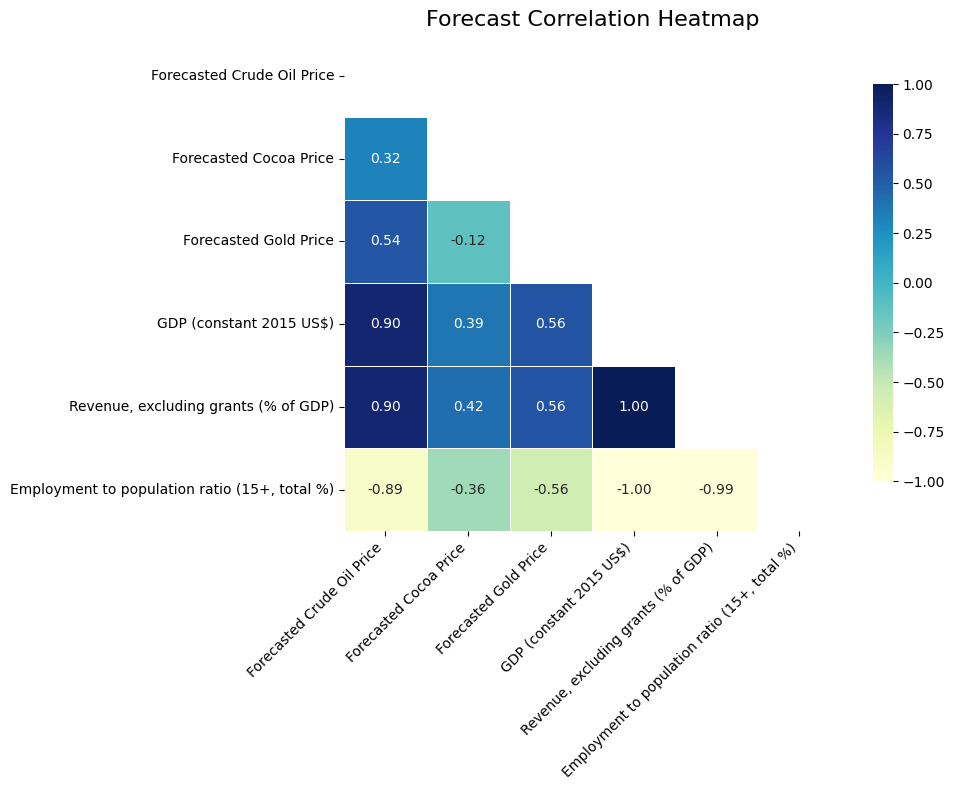

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# df = pd.read_csv("merged_macro_commodity.csv", parse_dates=['date'])
merged_df = pd.read_csv("merged_autogluon_forecasted_macro.csv", parse_dates=['date'])
df = merged_df[
    [
     'date',
     'Forecasted Crude Oil Price', 
     'Forecasted Cocoa Price', 
     'Forecasted Gold Price',
     'GDP (constant 2015 US$)', 
     'Revenue, excluding grants (% of GDP)', 
     'Employment to population ratio (15+, total %)'
    ]
]
df['date'] = pd.to_datetime(df['date'])

# Calculate the correlation matrix
corr = df.drop(columns=['date']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a custom diverging colormap
sns.heatmap(
    corr, 
    mask=mask, 
    cmap='YlGnBu',  # You can try 'Spectral' too
    vmax=1, 
    vmin=-1,
    center=0,
    annot=True, 
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title('Forecast Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
